# Movie Analysis Project

## Overview
This project assumes a scenario in which the goal is analyze and provide meaningful insights from publicly available data and provide recommendation to company from a Data Science perspective

### Business Problem
Microsoft sees all the big companies creating original video content and they want to get in on the fun. They have decided to create a new movie studio, but they don’t know anything about creating movies. The current study is focused on analyzing various movie review datasets and based on that provide a recommendation on viable pathway that will help Microsoft make decision on new movie production. 



#### Critical questions to ask
The study is based on finding answers to some key questions that will help to make meaningful recommendation: 
1. Which genre is rated high?
2. Which genre is more popularity?
3. Which genre has high profitablity?

## Data Loading and Preparation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('darkgrid')

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [2]:
# Read csv files
df_imdb_name = pd.read_csv('https://github.com/learn-co-curriculum/dsc-phase-1-project/raw/master/zippedData/imdb.name.basics.csv.gz')
df_imdb_aka = pd.read_csv('https://github.com/learn-co-curriculum/dsc-phase-1-project/raw/master/zippedData/imdb.title.akas.csv.gz')
df_imdb_crew = pd.read_csv('https://github.com/learn-co-curriculum/dsc-phase-1-project/raw/master/zippedData/imdb.title.crew.csv.gz')
df_imdb_principal = pd.read_csv('https://github.com/learn-co-curriculum/dsc-phase-1-project/raw/master/zippedData/imdb.title.principals.csv.gz')

df_imdb_basic = pd.read_csv('https://github.com/learn-co-curriculum/dsc-phase-1-project/raw/master/zippedData/imdb.title.basics.csv.gz')
df_imdb_ratings = pd.read_csv('https://github.com/learn-co-curriculum/dsc-phase-1-project/raw/master/zippedData/imdb.title.ratings.csv.gz')

### Load IMDB Datasets

In [3]:
display(df_imdb_name.head())
print('IMDB_name')
display(df_imdb_aka.head())
print('IMDB_aka')
display(df_imdb_basic.head())
print('IMDB_basic')
display(df_imdb_crew.head())
print('IMDB_crew')
display(df_imdb_principal.head())
print('IMDB_principal')
display(df_imdb_ratings.head())
print('IMDB_ratings')

,nconst,primary_name,birth_year,death_year,primary_profession,known_for_titles
0,nm0061671,Mary Ellen Bauder,NaN,NaN,"miscellaneous,production_manager,producer","tt0837562,tt2398241,tt0844471,tt0118553"
1,nm0061865,Joseph Bauer,NaN,NaN,"composer,music_department,sound_department","tt0896534,tt6791238,tt0287072,tt1682940"
2,nm0062070,Bruce Baum,NaN,NaN,"miscellaneous,actor,writer","tt1470654,tt0363631,tt0104030,tt0102898"
3,nm0062195,Axel Baumann,NaN,NaN,"camera_department,cinematographer,art_department","tt0114371,tt2004304,tt1618448,tt1224387"
4,nm0062798,Pete Baxter,NaN,NaN,"production_designer,art_department,set_decorator","tt0452644,tt0452692,tt3458030,tt2178256"


IMDB_name


,title_id,ordering,title,region,language,types,attributes,is_original_title
0,tt0369610,10,Джурасик свят,BG,bg,NaN,NaN,0.0
1,tt0369610,11,Jurashikku warudo,JP,NaN,imdbDisplay,NaN,0.0
2,tt0369610,12,Jurassic World: O Mundo dos Dinossauros,BR,NaN,imdbDisplay,NaN,0.0
3,tt0369610,13,O Mundo dos Dinossauros,BR,NaN,NaN,short title,0.0
4,tt0369610,14,Jurassic World,FR,NaN,imdbDisplay,NaN,0.0


IMDB_aka


,tconst,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"


IMDB_basic


,tconst,directors,writers
0,tt0285252,nm0899854,nm0899854
1,tt0438973,NaN,"nm0175726,nm1802864"
2,tt0462036,nm1940585,nm1940585
3,tt0835418,nm0151540,"nm0310087,nm0841532"
4,tt0878654,"nm0089502,nm2291498,nm2292011",nm0284943


IMDB_crew


,tconst,ordering,nconst,category,job,characters
0,tt0111414,1,nm0246005,actor,NaN,"[""The Man""]"
1,tt0111414,2,nm0398271,director,NaN,NaN
2,tt0111414,3,nm3739909,producer,producer,NaN
3,tt0323808,10,nm0059247,editor,NaN,NaN
4,tt0323808,1,nm3579312,actress,NaN,"[""Beth Boothby""]"


IMDB_principal


,tconst,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559
2,tt1042974,6.4,20
3,tt1043726,4.2,50352
4,tt1060240,6.5,21


IMDB_ratings


Quick evaluation of the IMDB datasets suggest, for the given time being, the IMDB basic and imdb ratings dataset seems to have immediate impacts to our study. While other data are useful (especially the information on directors and actors), these data needs more time for more pre-processing and cleanup. Therefore, we will focus on using the IMDB basic and rating dataset for this project. 

In [4]:
#  We will merge these two dataset on the primary key 'tconst'
df_imdb_merge = pd.merge(df_imdb_basic, df_imdb_ratings, on='tconst')

In [102]:
# Merge dataframes
df_imdb_merge = pd.merge(df_imdb_basic, df_imdb_ratings, on='tconst')

# rename columns, these will be used to merge with other dataframes later
df_imdb_merge.rename(columns = {"original_title": "title",
                                "start_year": "year",
                                "genres": "genre"}, inplace = True)

df_imdb_merge.drop(columns = ['tconst', 'primary_title'], inplace=True)

# Check to see how many rows lost in the process
print('No. of observations for imdb_basic:', df_imdb_basic.shape)
print('No. of observations for imdb_ratings:', df_imdb_ratings.shape)
print('No. of observations for imdb_crew:', df_imdb_crew.shape)
print('No. of observations for after merging imdb_basic and ratings:', df_imdb_merge.shape)

# df_imdb_merge = pd.merge(df_imdb_merge, df_imdb_crew, on='tconst')

No. of observations for imdb_basic: (146144, 6)
No. of observations for imdb_ratings: (73856, 3)
No. of observations for imdb_crew: (146144, 3)
No. of observations for after merging imdb_basic and ratings: (73856, 6)


In [475]:
# Lets replace the missing values. Although the  
df_imdb_merge.fillna(value=0, inplace=True)
df_imdb_merge['genre'] = df_imdb_merge['genre'].str.strip()
df_imdb_merge.head()

,runtime_minutes,averagerating,numvotes,title,year,genre
0,175.0,7.0,77,Sunghursh,2013,"Action,Crime,Drama"
1,114.0,7.2,43,Ashad Ka Ek Din,2019,"Biography,Drama"
2,122.0,6.9,4517,The Other Side of the Wind,2018,Drama
3,0.0,6.1,13,Sabse Bada Sukh,2018,"Comedy,Drama"
4,80.0,6.5,119,La Telenovela Errante,2017,"Comedy,Drama,Fantasy"


In [100]:
df_imdb_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73856 entries, 0 to 73855
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           73856 non-null  object 
 1   primary_title    73856 non-null  object 
 2   original_title   73856 non-null  object 
 3   start_year       73856 non-null  int64  
 4   runtime_minutes  66236 non-null  float64
 5   genres           73052 non-null  object 
 6   averagerating    73856 non-null  float64
 7   numvotes         73856 non-null  int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 5.1+ MB


One important factor a motin picture to be categorized as movie is runtime. AFI and BFI's definitions call any film longer than 40 minutes a feature. We will get rid of the movie that shorter than 40 minutes from our data. In addition to that, we will also try to remove some category that is not related to the movie business

In [103]:
# Remove some non-movie category:
df_imdb_merge_filter = df_imdb_merge[(df_imdb_merge['runtime_minutes'] >= 40)]
                                    

# Remove some non-movie category
df_imdb_merge_filter = df_imdb_merge[(df_imdb_merge['genre'] !='Documentary') & 
                                     (df_imdb_merge['genre'] !='Biography') & 
                                     (df_imdb_merge['genre'] !='History') &
                                     (df_imdb_merge['genre'] !='Music') &
                                     (df_imdb_merge['genre'] !='Reality-TV') & 
                                     (df_imdb_merge['genre'] != 'Sport') &
                                     (df_imdb_merge['genre'] != 'Short') &
                                     (df_imdb_merge['genre'] != 'News')
                                    ]
# df_imdb_merge_filter.head()

### Load TN Budget Dataset

TN dataset has important monetary information, and most of our analysis will be based on this dataset.

In [104]:
df_tn = pd.read_csv('https://github.com/learn-co-curriculum/dsc-phase-1-project/raw/master/zippedData/tn.movie_budgets.csv.gz')

In [480]:
display(df_tn.info())
display(df_tn.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


None

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [106]:
# Simple function to convert some currency values into numeric values

def conv_numeric(x):
    '''
    Convert string object to numeric type by removing '$' and delimiters
    Leave the numeric value as it is. 
    '''
    if isinstance(x, str):
        return float(x.replace(',', '').replace('$', ''))
    return float(x)

# Note: float function at the begining as it is applying on individual string

In [107]:
df_tn['production_budget'] = df_tn['production_budget'].apply(conv_numeric)
df_tn['domestic_gross'] = df_tn['domestic_gross'].apply(conv_numeric)
df_tn['worldwide_gross'] = df_tn['worldwide_gross'].apply(conv_numeric)

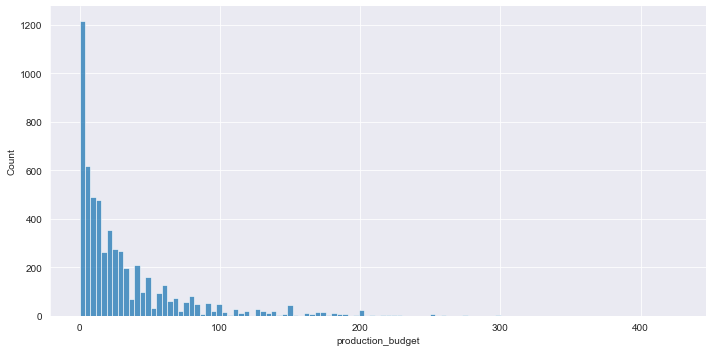

In [490]:
sns.displot(data=df_tn['production_budget']/1000000, aspect=2);

The budget dataset itself is not very useful, so we need to combine this with other dataset and make correlation against movie genre type. Next we will do some preprocessing so that we can merge this datasets to other datasets.

In [108]:
# we will extract 'year' and save it in a column
# later we will use this in conjunction with movie title to merge with imdb dataset

df_tn['release_date'] = pd.to_datetime(df_tn['release_date'])
df_tn['year'] = pd.DatetimeIndex(df_tn['release_date']).year
df_tn['title'] = df_tn['movie']

df_tn.drop(columns=['movie'], inplace=True)
df_tn.head()

,id,release_date,production_budget,domestic_gross,worldwide_gross,year,title
0,1,2009-12-18,425000000.0,760507625.0,2.776345e+09,2009,Avatar
1,2,2011-05-20,410600000.0,241063875.0,1.045664e+09,2011,Pirates of the Caribbean: On Stranger Tides
2,3,2019-06-07,350000000.0,42762350.0,1.497624e+08,2019,Dark Phoenix
3,4,2015-05-01,330600000.0,459005868.0,1.403014e+09,2015,Avengers: Age of Ultron
4,5,2017-12-15,317000000.0,620181382.0,1.316722e+09,2017,Star Wars Ep. VIII: The Last Jedi


In [109]:
df_tn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 5782 non-null   int64         
 1   release_date       5782 non-null   datetime64[ns]
 2   production_budget  5782 non-null   float64       
 3   domestic_gross     5782 non-null   float64       
 4   worldwide_gross    5782 non-null   float64       
 5   year               5782 non-null   int64         
 6   title              5782 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(1)
memory usage: 316.3+ KB


### Load BOM Datasets

In [110]:
df_bom = pd.read_csv('https://github.com/learn-co-curriculum/dsc-phase-1-project/raw/master/zippedData/bom.movie_gross.csv.gz')

In [111]:
df_bom.info()
display(df_bom.head(3))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010


In [112]:
# Apply numeric conversion
df_bom['foreign_gross'] = df_bom['foreign_gross'].apply(conv_numeric)

In [113]:
df_bom.isna().sum()

title                0
studio               5
domestic_gross      28
foreign_gross     1350
year                 0
dtype: int64

The missing information may be present in the TN dataset. But, most of these information are already in the TN dataset, the only new information here is Studio, which may be very useful, so we will merge this dataset anyway.

### Load TMDB movies dataset

In [118]:
df_tmdb_raw = pd.read_csv('https://github.com/learn-co-curriculum/dsc-phase-1-project/raw/master/zippedData/tmdb.movies.csv.gz')

In [35]:
display(df_tmdb.info())
display(df_tmdb.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26517 entries, 0 to 26516
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         26517 non-null  int64  
 1   genre_ids          26517 non-null  object 
 2   id                 26517 non-null  int64  
 3   original_language  26517 non-null  object 
 4   original_title     26517 non-null  object 
 5   popularity         26517 non-null  float64
 6   release_date       26517 non-null  object 
 7   title              26517 non-null  object 
 8   vote_average       26517 non-null  float64
 9   vote_count         26517 non-null  int64  
dtypes: float64(2), int64(3), object(5)
memory usage: 2.0+ MB


None

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186


We can see some genre id represented by some numbers. We can actually find the exact genre if we go to the tmdb genre website [here](https://www.themoviedb.org/talk/5daf6eb0ae36680011d7e6ee)

Below is a dictionary of 'Movie' genres pertaining the number represantative

In [115]:
temp = {'Action': 28,
             'Adventure': 12,
             'Animation': 16,
             'Comedy': 35,
             'Crime': 80,
             'Documentary': 99,
             'Drama': 18,
             'Family': 10751,
             'Fantasy': 14,
             'History':36,
             'Horror': 27,
             'Music': 10402,
             'Mystery': 9648,
             'Romance': 10749,
             'Science Fiction': 878,
             'TV Movie': 10770,
             'Thriller': 53,
             'War': 1075,
             'Western': 37}

# Switch key-value pairs
tmdb_genre = {}
for k,v in temp.items():
    tmdb_genre[v] = k

In [116]:
def str_replace(input_str, key_dict=tmdb_genre, unknown_genre_str="UNK"):
    '''
    Replace genre id in integer format by text.
    Strip and split non-alphabetic characters and unpack into a list of genres.
    
    '''
    final_str = ""
    # Remove the first and last characters []
    final_str = input_str[1:-1]
    # Split the string to get list of numbers
    final_str = final_str.strip().split(',')
    # Assuming all strings are integers
    #TODO: Find when int() cast doesn't work
    try:
        final_str = [int(x) for x in final_str]
        # Replace numbers with words
        final_str = [key_dict.get(k,unknown_genre_str) for k in final_str]
        # Make one big string to return
    except:
        final_str = ""
    return ','.join(final_str)

In [119]:
df_tmdb = df_tmdb_raw.copy(deep=True)
df_tmdb['genre'] = df_tmdb['genre_ids'].apply(str_replace)


# we will extract 'year' and save it in a column.
df_tmdb['year'] = pd.DatetimeIndex(df_tmdb['release_date']).year

df_tmdb.drop(columns= ['Unnamed: 0','genre_ids', 'id', 'original_language', 'original_title'], inplace=True)
df_tmdb.head()

,popularity,release_date,title,vote_average,vote_count,genre,year
0,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788,"Adventure,Fantasy,Family",2010
1,28.734,2010-03-26,How to Train Your Dragon,7.7,7610,"Fantasy,Adventure,Animation,Family",2010
2,28.515,2010-05-07,Iron Man 2,6.8,12368,"Adventure,Action,Science Fiction",2010
3,28.005,1995-11-22,Toy Story,7.9,10174,"Animation,Comedy,Family",1995
4,27.920,2010-07-16,Inception,8.3,22186,"Action,Science Fiction,Adventure",2010


TMDB dataset has some vital information like popularity, average voting, and vote count. IMDB rating dataset also has rating information, but they are comparable. For the purpose of joining different datasets, we need a common key. In our case, we will use movie 'title' as the primary key however, We have noticed, there are many instances of title of a movie repeated. In that case, we need a second key, and we will use 'year' for that purpose.

### Load Rotten Tomatoes Dataset

In [120]:
# Read .tsv files
df_rt_movies = pd.read_csv('https://github.com/learn-co-curriculum/dsc-phase-1-project/raw/master/zippedData/rt.movie_info.tsv.gz', delimiter = '\t')

# following data is in different latin1  codec latin
df_rt_reviews = pd.read_csv('https://github.com/learn-co-curriculum/dsc-phase-1-project/raw/master/zippedData/rt.reviews.tsv.gz', delimiter = '\t', encoding='latin1')

In [121]:
df_rt_movies.isna().sum()

id                 0
synopsis          62
rating             3
genre              8
director         199
writer           449
theater_date     359
dvd_date         359
currency        1220
box_office      1220
runtime           30
studio          1066
dtype: int64

There is alot of missing data on the Rotten Tomatoes and its features may not be super helpful for our analysis. We will ignore this dataset for our purpose

## Combine datasets from different source into a single dataframe
Differnt websites used different naming conventions, and therefore there is huge inconsistencies in the title. When merge different dataframes, we expect loss of information due to naming mismatch. Nevertheless, we will try to minimize the mismatch as much as possible.

In [122]:
# We will try clean up as much possible the movie title for better match

def string_clean(x):
    '''
    Simple string manipulation to replace,remove inconsistencies in naming
    '''
    x = x.lower()
    x = x.replace('&', 'and')
    x = x.replace('#', '')
    x = x.replace('$', '')
    x = x.replace('*', '')
    x = x.replace('-', '')
    x = x.replace(',', '')
    x = x.replace('_', '')
    x = x.replace(';', '')
    x = x.replace('[', '')
    x = x.replace(']', '')
    x = x.replace('(', '')
    x = x.replace(')', '')
    x = x.replace('+', '')
    x = x.replace('.', '')
    x = x.replace('/', '')
    x = x.strip()
    return x

In [123]:
df_tn['title_edit'] = df_tn['title'].apply(string_clean)
df_bom['title_edit'] = df_bom['title'].apply(string_clean)
df_imdb_merge['title_edit'] = df_imdb_merge['title'].apply(string_clean)
df_tmdb['title_edit'] = df_tmdb['title'].apply(string_clean)

In [124]:
# Merge dataset,ideally should be using left join, but that resulted into some problem in comparing
# revenue information. 

df_merge1 = pd.merge(df_tn, df_imdb_merge, on= ['title_edit', 'year'])
df_merge1.rename(columns = {"title_x": "title"},inplace = True)
df_merge2 = pd.merge(df_merge1, df_tmdb, on= ['title_edit', 'year'])
df_merge2.rename(columns = {"title_x": "title"},inplace = True)
df_merge3 = pd.merge(df_merge2, df_bom, on= ['title_edit', 'year'])
df_merge3.rename(columns = {"title_x": "title"},inplace = True)

df_merge = df_merge3.copy(deep=True)

print('No. of observations for TN budget dataset:', df_tn.shape[0])
print('No. of observations for IMDB dataset:', df_imdb_merge.shape[0])
print('No. of observations for BOM dataset:', df_bom.shape[0])
print('No. of observations for TMDB dataset:', df_tmdb.shape[0])

print('No. of observation after merge IMDB :', df_merge1.shape[0])
print('No. of observation after merge TMDB :', df_merge2.shape[0])
print('No. of observation after merge BOM :', df_merge3.shape[0])

df_merge.head()

No. of observations for TN budget dataset: 5782
No. of observations for IMDB dataset: 73856
No. of observations for BOM dataset: 3387
No. of observations for TMDB dataset: 26517
No. of observation after merge IMDB : 1550
No. of observation after merge TMDB : 1541
No. of observation after merge BOM : 1197


,id,release_date_x,production_budget,domestic_gross_x,worldwide_gross,year,title,title_edit,title_y,runtime_minutes,...,popularity,release_date_y,title_y,vote_average,vote_count,genre_y,title_y,studio,domestic_gross_y,foreign_gross
0,2,2011-05-20,410600000.0,241063875.0,1.045664e+09,2011,Pirates of the Caribbean: On Stranger Tides,pirates of the caribbean: on stranger tides,Pirates of the Caribbean: On Stranger Tides,136.0,...,30.579,2011-05-20,Pirates of the Caribbean: On Stranger Tides,6.4,8571,"Adventure,Action,Fantasy",Pirates of the Caribbean: On Stranger Tides,BV,241100000.0,804600000.0
1,4,2015-05-01,330600000.0,459005868.0,1.403014e+09,2015,Avengers: Age of Ultron,avengers: age of ultron,Avengers: Age of Ultron,141.0,...,44.383,2015-05-01,Avengers: Age of Ultron,7.3,13457,"Action,Adventure,Science Fiction",Avengers: Age of Ultron,BV,459000000.0,946400000.0
2,7,2018-04-27,300000000.0,678815482.0,2.048134e+09,2018,Avengers: Infinity War,avengers: infinity war,Avengers: Infinity War,149.0,...,80.773,2018-04-27,Avengers: Infinity War,8.3,13948,"Adventure,Action,Fantasy",Avengers: Infinity War,BV,678800000.0,1369.5
3,9,2017-11-17,300000000.0,229024295.0,6.559452e+08,2017,Justice League,justice league,Justice League,120.0,...,34.953,2017-11-17,Justice League,6.2,7510,"Action,Adventure,Fantasy,Science Fiction",Justice League,WB,229000000.0,428900000.0
4,9,2017-11-17,300000000.0,229024295.0,6.559452e+08,2017,Justice League,justice league,Justice League,120.0,...,34.953,2017-11-17,Justice League,6.2,7510,"Action,Adventure,Fantasy,Science Fiction",Justice League,WB,229000000.0,428900000.0


We can see, the total number of rows has reduced down, this is still good number to extract quantitative insights. However, the for qualitative analysis, we might refer back to individual dataset later. We will first focus on this combined dataset for global interpretation, if needed, we will also explore the individual dataset. The operation below might help to fill in information that is present in different datasets.

In [125]:
df_merge['genre'] = df_merge.genre_x.combine_first(df_merge.genre_y)
df_merge['rating'] = df_merge.averagerating.combine_first(df_merge.vote_average)
df_merge['domestic_gross'] = df_merge.domestic_gross_x.combine_first(df_merge.domestic_gross_y)
df_merge['release_date'] = df_merge.release_date_x.combine_first(df_merge.release_date_y)

In [126]:
final_columns_to_drop = ['id', 'release_date_x', 'domestic_gross_x', 'title_edit', 'averagerating',
                         'title_y', 'genre_x', 'release_date_y', 'title_y', 'vote_average',
                         'genre_y', 'title_y', 'domestic_gross_y', 'foreign_gross']
df_merge.drop(columns = final_columns_to_drop, inplace=True)

In [427]:
#df_merge = df_merge.loc[:, ~df_merge.columns.duplicated()]

In [127]:
# drop rows with missing domestic gross and fix minor edits
df_merge = df_merge[(df_merge['domestic_gross']) != 0]
df_merge = df_merge[(df_merge['production_budget']) != 0]
df_merge = df_merge[(df_merge['worldwide_gross']) != 0]

df_merge['genre'] = df_merge['genre'].str.replace('Science Fiction', 'Sci-Fi')

In [128]:
# Perform some arithmatic

# Normalize to million
df_merge['production_budget_m'] = df_merge['production_budget']/1000000
df_merge['domestic_gross_m'] = df_merge['domestic_gross']/1000000
df_merge['worldwide_gross_m'] = df_merge['worldwide_gross']/1000000
df_merge['foreign_gross_m'] = df_merge['worldwide_gross_m'] - df_merge['domestic_gross_m']

df_merge['worldwide_profit_m'] = df_merge['worldwide_gross_m'] - df_merge['production_budget_m']
df_merge['domestic_profit_m'] = df_merge['domestic_gross_m'] - df_merge['production_budget_m']


# Calculate net margin
df_merge['domestic_margin'] = df_merge['domestic_profit_m'] / df_merge['domestic_gross_m']  
df_merge['worldwide_margin'] = df_merge['worldwide_profit_m'] / df_merge['worldwide_gross_m'] 

# df_merge.head()

### Assigning Genre Category

Genre separation is one of the major task as lot of movie are defined by multiple genres. This will be critical in analyzing and comparing budget and other information with a particular genre. For this analysis, we have used two approaches: 
1. Separate genre combination into two columns of primary and secondary genre type.This is based on the assumption that the first position in a genre combination string is associated with primary genre of the move type.
2. We can create a genre table and assign 1 or 0 if the particular genre is present in the genre combination tag. In this case, any genre mentioned will have same importance. We will see, if this method will be any useful later, but for now, our analysis will be based on primary and secondary genres.

In [129]:
# Approach 1: Add primary and secondary genre column
df_merge['prim_genre'] = df_merge['genre'].str.split(',', expand = True)[0]
df_merge['second_genre'] = df_merge['genre'].str.split(',', expand = True)[1]

In [130]:
df_merge.head()

,production_budget,worldwide_gross,year,title,runtime_minutes,numvotes,popularity,vote_count,studio,genre,...,production_budget_m,domestic_gross_m,worldwide_gross_m,foreign_gross_m,worldwide_profit_m,domestic_profit_m,domestic_margin,worldwide_margin,prim_genre,second_genre
0,410600000.0,1.045664e+09,2011,Pirates of the Caribbean: On Stranger Tides,136.0,447624,30.579,8571,BV,"Action,Adventure,Fantasy",...,410.6,241.063875,1045.663875,804.600000,635.063875,-169.536125,-0.703283,0.607331,Action,Adventure
1,330600000.0,1.403014e+09,2015,Avengers: Age of Ultron,141.0,665594,44.383,13457,BV,"Action,Adventure,Sci-Fi",...,330.6,459.005868,1403.013963,944.008095,1072.413963,128.405868,0.279748,0.764364,Action,Adventure
2,300000000.0,2.048134e+09,2018,Avengers: Infinity War,149.0,670926,80.773,13948,BV,"Action,Adventure,Sci-Fi",...,300.0,678.815482,2048.134200,1369.318718,1748.134200,378.815482,0.558054,0.853525,Action,Adventure
3,300000000.0,6.559452e+08,2017,Justice League,120.0,329135,34.953,7510,WB,"Action,Adventure,Fantasy",...,300.0,229.024295,655.945209,426.920914,355.945209,-70.975705,-0.309905,0.542645,Action,Adventure
4,300000000.0,6.559452e+08,2017,Justice League,120.0,329135,34.953,7510,WB,"Action,Adventure,Fantasy",...,300.0,229.024295,655.945209,426.920914,355.945209,-70.975705,-0.309905,0.542645,Action,Adventure


In [131]:
# Approach 2: add genre table of each genres and assign True or False

def make_genre_columns(df, genre_col):
    '''
    Split the individual genre type and put them into a separate column
    
    '''    
    # Get list of genres 
    list_of_all_genres = ','.join(str(x) for x in genre_col.unique())    
    unique_genres = {x for x in list_of_all_genres.split(',')}   # set comprehension
    print(unique_genres)
    
    # Get columns for each genre; values 0 or 1 if in that genre
    # make a copy of the dataframe
    df_copy = df.copy(deep=True)
    
    for genre in unique_genres:
        df_copy[genre] = df_copy.apply(lambda x: int(genre in str(x.genre)), axis=1) 
        
       
    return df_copy 

In [132]:
df_merge = make_genre_columns(df_merge, df_merge['genre'])

{'Musical', 'Fantasy', 'Music', 'Family', 'Horror', 'War', 'History', 'Documentary', 'Western', 'Comedy', 'Mystery', 'Thriller', 'Drama', 'Biography', 'Adventure', 'Crime', 'Sci-Fi', 'Sport', 'Romance', 'Animation', 'Action'}


In [133]:
# When using left join, use this!!!
# genres_to_discard = ['', 'Musical', 'Sport', 'Documentary', 'nan', 'History', 'Music', 'Biography', 'UNK']
# df_merge.drop(columns= genres_to_discard, inplace=True)

In [134]:
genres_to_discard = ['Musical', 'Sport', 'Documentary', 'History', 'Music', 'Biography']
df_merge.drop(columns= genres_to_discard, inplace=True)

In [135]:
# finally drop some unwanted columns
df_merge.drop_duplicates(subset='title', inplace=True)
df_merge = df_merge[(df_merge['prim_genre'] != '') &
                    (df_merge['prim_genre'] != 'Musical') &
                    (df_merge['prim_genre'] != 'Sport') &
                    (df_merge['prim_genre'] != 'nan') &
                    (df_merge['prim_genre'] != 'History') &
                    (df_merge['prim_genre'] != 'Music') &
                    (df_merge['prim_genre'] != 'Biography') &
                    (df_merge['prim_genre'] != 'UNK') 
                     ]

## Some Exploratory Analysis

We have almost covered majority of the pre-processing. Now we can make some exploratory analysis to draw some conclusions about the movie dataset.

### Top 10 most expensive movies

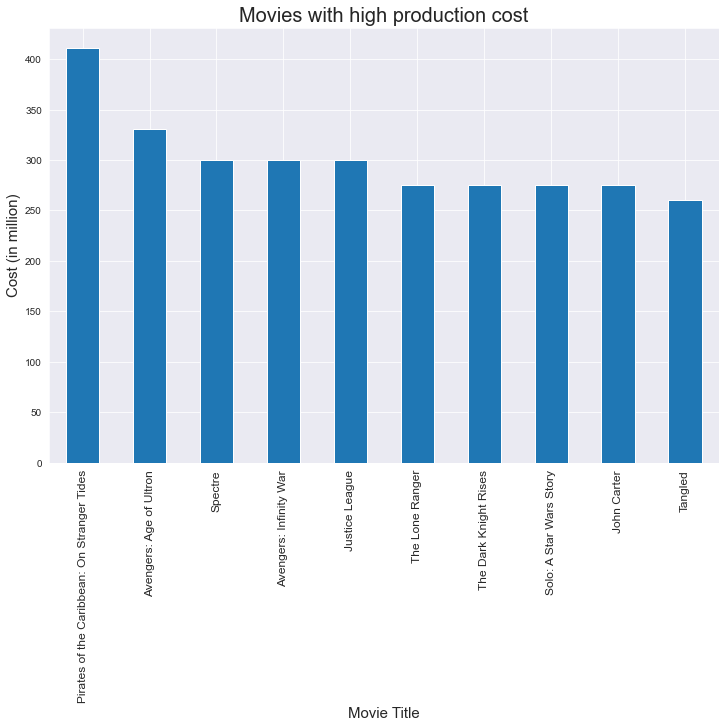

In [136]:
df_merge.groupby('title')['production_budget_m'].sum().sort_values(ascending=False).head(10).plot(kind='bar', figsize=(12,8))
plt.xlabel('Movie Title', fontsize=15)
plt.ylabel('Cost (in million)', fontsize=15)
plt.xticks(rotation='vertical', fontsize=12)
plt.title('Movies with high production cost', fontsize=20);

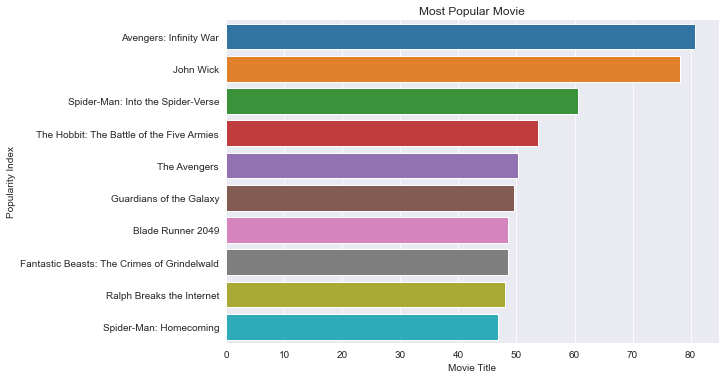

In [137]:
# df_tmdb.groupby('title')['popularity'].mean().sort_values(ascending=False).head(10).plot(kind='bar', color='purple', figsize=(12,8))

data = pd.DataFrame(df_tmdb.groupby('title')['popularity'].mean().sort_values(ascending=False).head(10))
data.reset_index(inplace=True)
ax = sns.catplot(data = data, y='title', x='popularity', orient='h', kind='bar', aspect=2)
plt.xlabel('Movie Title')
plt.ylabel('Popularity Index')
plt.xticks(rotation= None)
plt.title('Most Popular Movie');

### Top 10 movie with higest rating

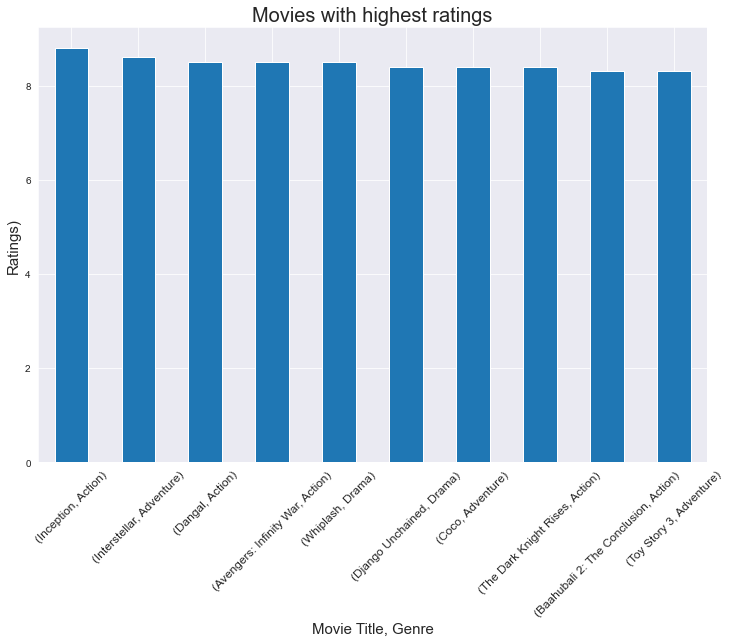

In [542]:
df_merge.groupby(['title', 'prim_genre'])['rating'].mean().sort_values(ascending=False).head(10).plot(kind='bar', figsize=(12,8))
plt.xlabel('Movie Title, Genre', fontsize=15)
plt.ylabel('Ratings)', fontsize=15)
plt.xticks(rotation=45, fontsize=12)
plt.title('Movies with highest ratings', fontsize=20);
plt.savefig('Top10_Movies_with_highest_rating_by_genres.png')

The Top 10 expensive movie might be misleading. This is due to the fact that we lost so much of the datapoints.Nevertheless, we will be using this merged data for cost-profit analysis. But before that, lets go back to TMDB dataset which has more datapoints to evaluate poularity

In [138]:
df_tmdb.shape

(26517, 8)

### It might be more insightful to evaluate TMDB dataset Rating and popularity as it has more datapoints.

In [139]:
df_tmdb.head()

,popularity,release_date,title,vote_average,vote_count,genre,year,title_edit
0,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788,"Adventure,Fantasy,Family",2010,harry potter and the deathly hallows: part 1
1,28.734,2010-03-26,How to Train Your Dragon,7.7,7610,"Fantasy,Adventure,Animation,Family",2010,how to train your dragon
2,28.515,2010-05-07,Iron Man 2,6.8,12368,"Adventure,Action,Science Fiction",2010,iron man 2
3,28.005,1995-11-22,Toy Story,7.9,10174,"Animation,Comedy,Family",1995,toy story
4,27.920,2010-07-16,Inception,8.3,22186,"Action,Science Fiction,Adventure",2010,inception


If we look at the genre description of movies, many movies has mixed genre description. In that regard, if we consider the first genre to be the primary genre, we can get some insights about that. We will have to assign genre for each movie: We will apply first approach of primary and secondary

In [140]:
# Approach 1: Add primary and secondary genre column
df_tmdb['prim_genre'] = df_tmdb['genre'].str.split(',', expand = True)[0]
df_tmdb['second_genre'] = df_tmdb['genre'].str.split(',', expand = True)[1]

In [141]:
# Remove some genres we are not interested

df_tmdb = df_tmdb[(df_tmdb['prim_genre']) != 'Music']
df_tmdb = df_tmdb[(df_tmdb['prim_genre']) != 'TV Movie']
df_tmdb = df_tmdb[(df_tmdb['prim_genre']) != 'UNK']
df_tmdb = df_tmdb[(df_tmdb['prim_genre']) != 'Documentary']
df_tmdb = df_tmdb[(df_tmdb['prim_genre']) != 'History']
df_tmdb = df_tmdb[(df_tmdb['prim_genre']) != '']

### Count: How many movies have been produced under each genre categories? 

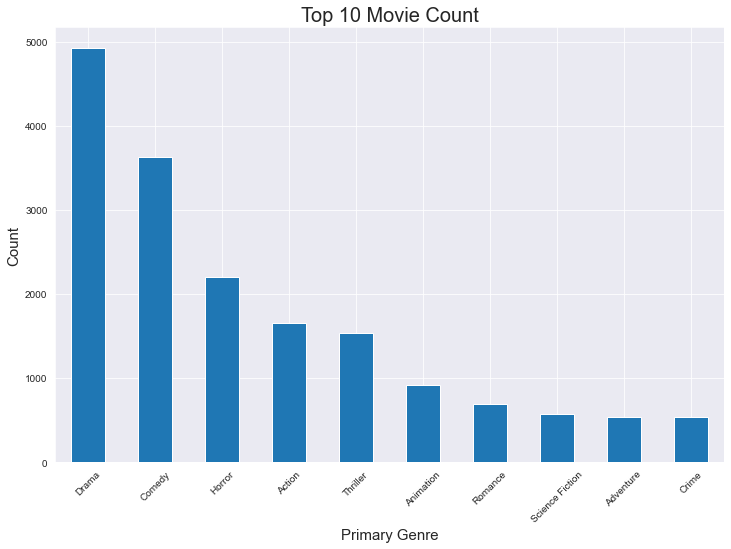

In [595]:
df_tmdb.groupby(['prim_genre'])['title'].count().sort_values(ascending=False).head(10).plot(kind='bar', figsize=(12,8))
plt.xlabel('Primary Genre', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.xticks(rotation= 45)
plt.title('Top 10 Movie Count', fontsize=20);
plt.savefig('Movie_genre_distribution.png')

### Ratings: What are the highest rated genres? 

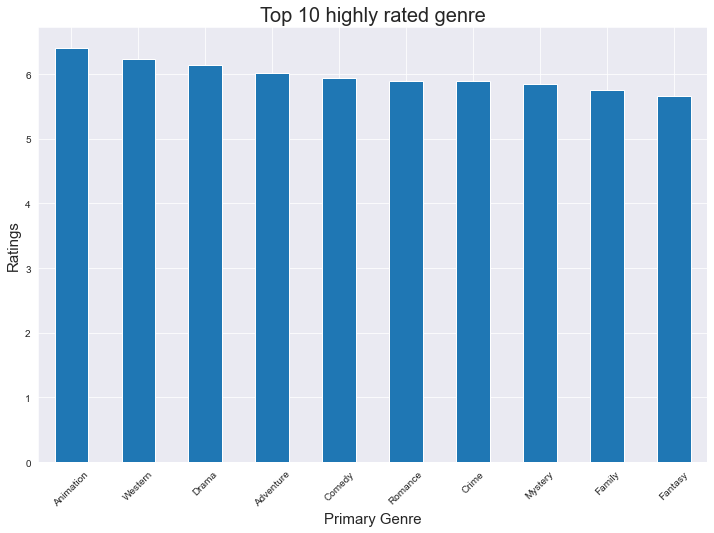

In [142]:
df_tmdb.groupby(['prim_genre'])['vote_average'].mean().sort_values(ascending=False).head(10).plot(kind='bar', figsize=(12,8))
plt.xlabel('Primary Genre', fontsize=15)
plt.ylabel('Ratings', fontsize=15)
plt.xticks(rotation= 45)
plt.title('Top 10 highly rated genre', fontsize=20);
plt.savefig('Top10_highly_rated_movie_genre.png')

### Current Trend in Movie Ratings

In [143]:
# Create pivot table of genre vs year of attributes to be mapped
df_tmdb_pivot_rating = pd.pivot_table(df_tmdb, values='vote_average', index='prim_genre', columns='year', aggfunc='mean')
# df_tmdb_pivot_rating.head()

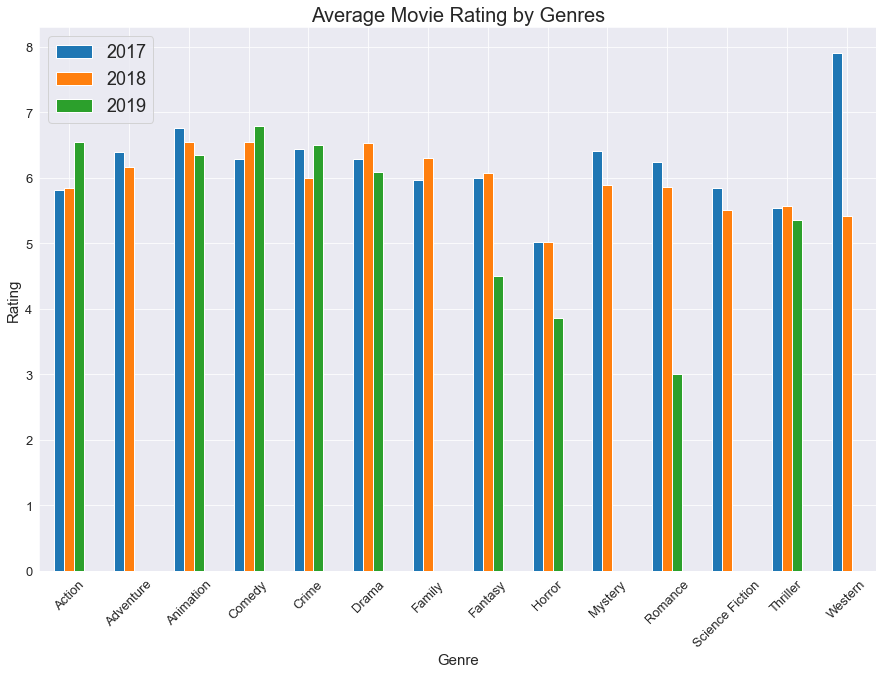

In [144]:
df_tmdb_pivot_rating.iloc[:, 60:63].plot(kind='bar',figsize = (15,10),fontsize=13)
plt.title("Average Movie Rating by Genres", fontsize = 20)
plt.ticklabel_format(style='plain', axis='y',useOffset=False)
plt.ylabel("Rating", fontsize = 15)
plt.xlabel("Genre", fontsize = 15)
plt.xticks(rotation=45)
plt.legend(prop={'size':18});
plt.savefig('Average_yearly_movie_rating_by_genre.png')

Ratings itself is a vague interpretation of the audience sentiment. Here we don't see a huge shift in ratings, rather a gradual transition. But, if combined with other information it can give a confidence in our market analysis. Let's look at another index to infer market sentiment

### Popularity: Which genre is the most popular?

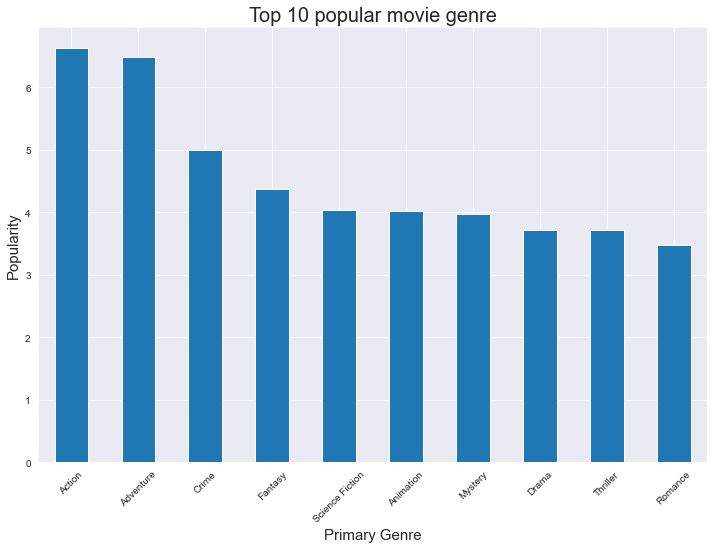

In [602]:
df_tmdb.groupby(['prim_genre'])['popularity'].mean().sort_values(ascending=False).head(10).plot(kind='bar', figsize=(12,8))
plt.xlabel('Primary Genre', fontsize=15)
plt.ylabel('Popularity', fontsize=15)
plt.xticks(rotation= 45)
plt.title('Top 10 popular movie genre', fontsize=20);
plt.savefig('Top10_popular_movie_genre.png')

### Current trend in Popularity

In [619]:
# Create pivot table of genre vs year of attributes to be mapped
df_tmdb_pivot_popularity = pd.pivot_table(df_tmdb, values='popularity', index='prim_genre', columns='year', aggfunc='mean')
# df_tmdb_pivot_popularity.head()

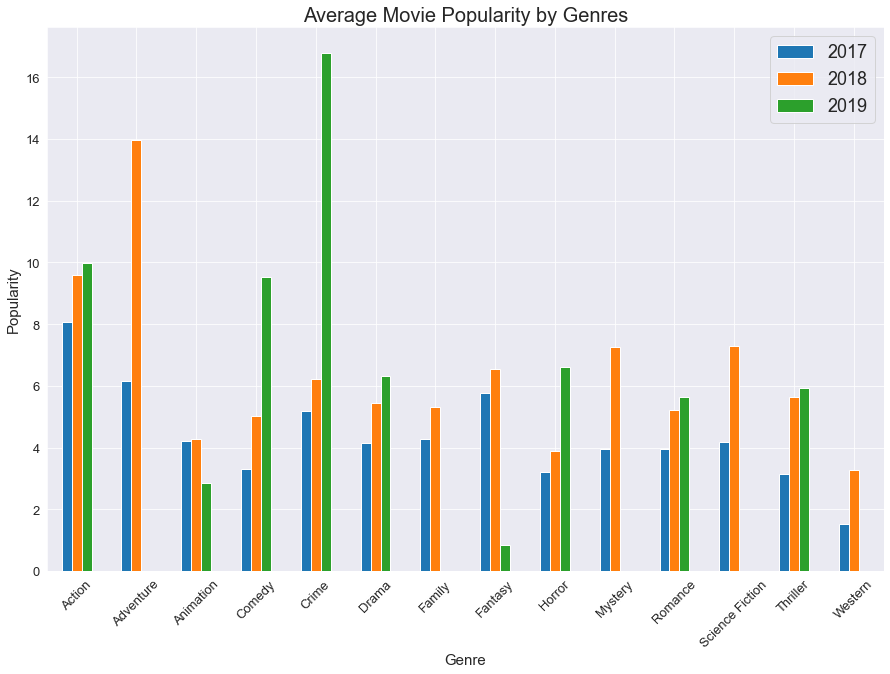

In [613]:
df_tmdb_pivot_popularity.iloc[:, 60:63].plot(kind='bar',figsize = (15,10),fontsize=13)
plt.title("Average Movie Popularity by Genres", fontsize = 20)
plt.ticklabel_format(style='plain', axis='y',useOffset=False)
plt.ylabel("Popularity", fontsize = 15)
plt.xlabel("Genre", fontsize = 15)
plt.xticks(rotation=45)
plt.legend(prop={'size':18});
plt.savefig('Average_yearly_movie_popularity_by_genre.png')

We see, 'action' genre is conistently getting high rating and popularity. The sharp peak on the 'crime'
genre is an outlier, and may not driving force, because the total number of movies  production under this category is very low. 

### Audience Participation: Which genre gets more response from the audiences? 

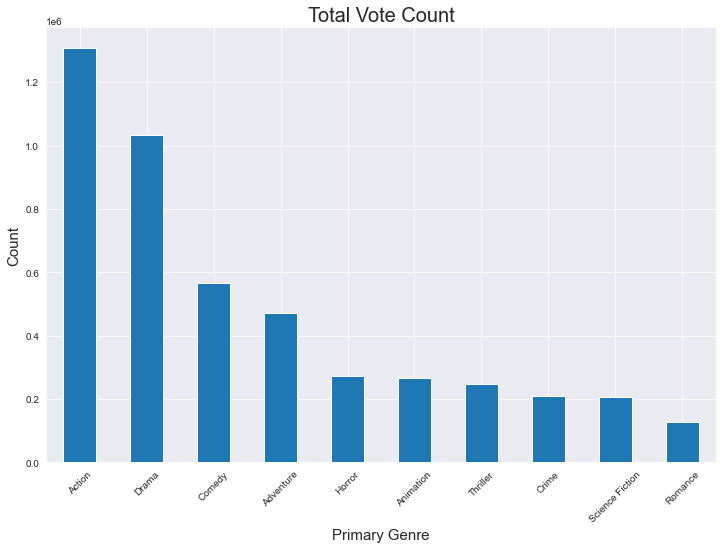

In [617]:
df_tmdb.groupby(['prim_genre'])['vote_count'].sum().sort_values(ascending=False).head(10).plot(kind='bar', figsize=(12,8))
plt.xlabel('Primary Genre', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.xticks(rotation= 45)
plt.title('Total Vote Count', fontsize=20);
plt.savefig('Top10_viewer_participation_by_genre.png')

I included this figure here to emphasize how people engage with particular genre. We see, 'action' and 'dram' category draws more attention. But some genres like 'animation' (which has good return on investment, which we will see later) doesnt seem to engage people much.

### Which genre is likely to be more profitable?

In [552]:
# let calculate some statistics and group by year 
df_merge_prim_genre_avg = df_merge.groupby('prim_genre').mean()
df_merge_prim_genre_sum = df_merge.groupby('prim_genre').sum()
df_merge_prim_genre_med = df_merge.groupby('prim_genre').median()
df_merge_prim_genre_std = df_merge.groupby('prim_genre').std()

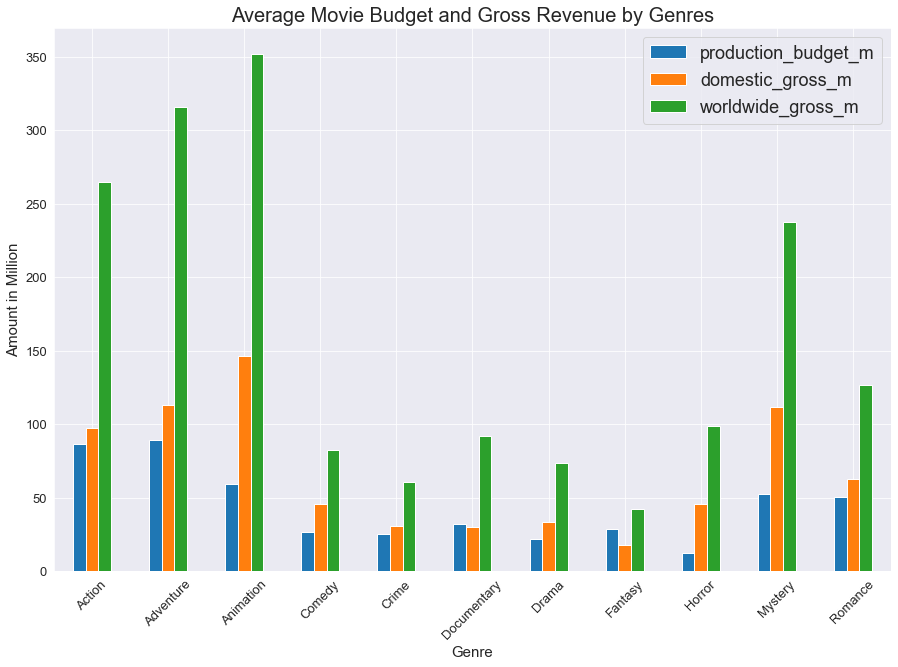

In [534]:
df_merge_prim_genre_avg.iloc[:, 9:12].plot(kind='bar',figsize = (15,10),fontsize=13)
plt.title("Average Movie Budget and Gross Revenue by Genres", fontsize = 20)
plt.ticklabel_format(style='plain', axis='y',useOffset=False)
plt.ylabel("Amount in Million", fontsize = 15)
plt.xlabel("Genre", fontsize = 15)
plt.xticks(rotation=45)
plt.legend(prop={'size':18});
plt.savefig('Average_movie_revenue_by_genres.png')

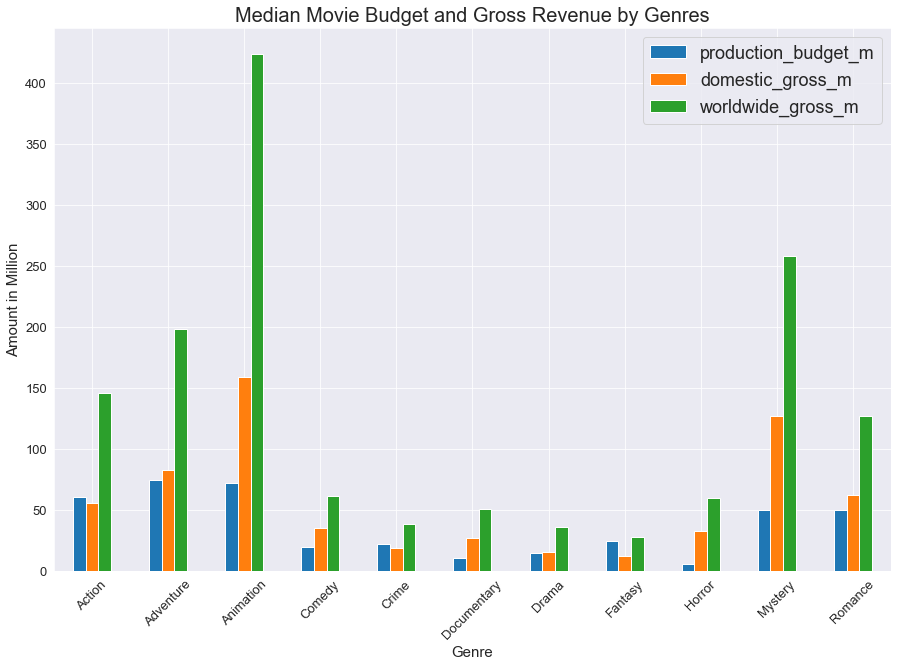

In [556]:
df_merge_prim_genre_med.iloc[:, 9:12].plot(kind='bar',figsize = (15,10),fontsize=13)
plt.title("Median Movie Budget and Gross Revenue by Genres", fontsize = 20)
plt.ticklabel_format(style='plain', axis='y',useOffset=False)
plt.ylabel("Amount in Million", fontsize = 15)
plt.xlabel("Genre", fontsize = 15)
plt.xticks(rotation=45)
plt.legend(prop={'size':18});
# plt.savefig('Average_movie_revenue_by_genres.png')

Both mean and median values for the revenue are comparable. We see 'action', 'adventure' and 'animation' and 'mystery' genre are top performing. The high profit margin here migh be little biased and the currentdataset is not adquate. But, compared with ratings and popularity data, 'action' genre seems to maintian a consistent record. 

### Domestic vs Worldwide proft

In [528]:
df_merge_prim_genre_avg.columns

Index(['production_budget', 'worldwide_gross', 'year', 'runtime_minutes',
       'numvotes', 'popularity', 'vote_count', 'rating', 'domestic_gross',
       'production_budget_m', 'domestic_gross_m', 'worldwide_gross_m',
       'foreign_gross_m', 'worldwide_profit_m', 'domestic_profit_m',
       'domestic_margin', 'worldwide_margin', 'Drama', 'Family', 'Mystery',
       'Animation', 'War', 'Fantasy', 'Western', 'Crime', 'Horror', 'Romance',
       'Sci-Fi', 'Comedy', 'Adventure', 'Thriller', 'Action', 'Musical',
       'Sport', 'Documentary', 'History', 'Music', 'Biography'],
      dtype='object')

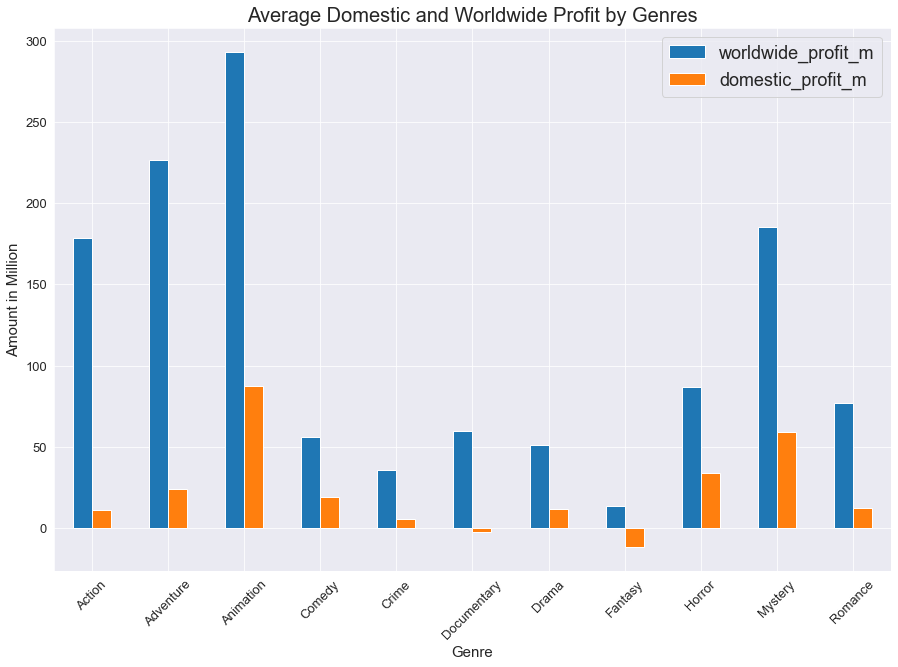

In [533]:
df_merge_prim_genre_avg.iloc[:, 13:15].plot(kind='bar',figsize = (15,10),fontsize=13)
plt.title("Average Domestic and Worldwide Profit by Genres", fontsize = 20)
plt.ticklabel_format(style='plain', axis='y',useOffset=False)
plt.ylabel("Amount in Million", fontsize = 15)
plt.xlabel("Genre", fontsize = 15)
plt.xticks(rotation=45)
plt.legend(prop={'size':18});
plt.savefig('Average_profit_by_genres.png')

There is a huge difference in domestic vs worldwide revenue. 

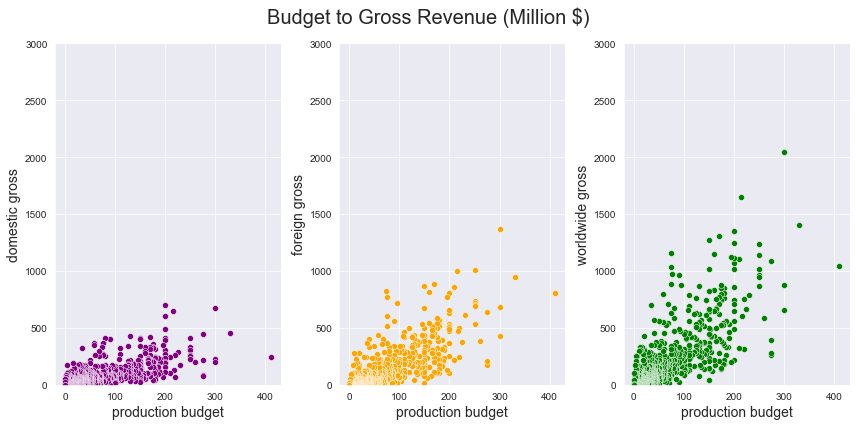

In [516]:
# Compare Gross Revenues
fig, axes = plt.subplots(nrows=1, ncols=3, figsize = (12,6))
fig.set_tight_layout(True)
sns.scatterplot(x=df_merge['production_budget_m'], y=df_merge['domestic_gross_m'], color='purple', ax=axes[0])
sns.scatterplot(x=df_merge['production_budget_m'], y=df_merge['worldwide_gross_m'], color='green', ax=axes[2])
sns.scatterplot(x=df_merge['production_budget_m'], y=df_merge['foreign_gross_m'], color='orange', ax=axes[1])

fig.suptitle("Budget to Gross Revenue (Million $)", fontsize=20)
axes[0].set_ylabel("domestic gross", fontsize=14)
axes[1].set_ylabel("foreign gross", fontsize=14)
axes[2].set_ylabel("worldwide gross", fontsize=14)

axes[0].set_xlabel("production budget", fontsize=14)
axes[1].set_xlabel("production budget", fontsize=14)
axes[2].set_xlabel("production budget", fontsize=14)

axes[0].set_ylim([0,3000])
axes[1].set_ylim([0,3000])
axes[2].set_ylim([0,3000])

plt.show();
# plt.savefig('Budget_to_gross_revenue.png')

This result also supports that the worldwide gross is very critical to maintain the overall profit.

# Conclusion

We have found that the animation movies have larger gross revenue, but its cost is higher overall. However, its ratings and popularity are not on the top side, and this is probably because of some of high performing movie such as Avatar might be skewing data. Nevertheless, it is definitely a promising genre especially for Microsoft, who can leverage its computer technology.

But in the broader sense, a more consistency in terms of revenue and popularity is critical for a long term business. In this regard, the 'action' and 'adventure' genre seems to provide consistency in maintaining top ratings, popularity and gross revenue. 

There is another genre 'mystery' which has also healthy average gross revenue, but their marketshare is not even in the top 10 and comparably less popular genre. 

Analysis of revenue data clearly shows international market has huge impact on overall gross revenue.
It is however important to remember, how much international audience respond to the survey so that the ratings and popularity data are consistent. However, international target is critical going forward. 




### Future Improvements
Audience sentiment analysis was performed on TMDB data which has significantly larger number of data points than the revenue data. Therefore, the revenue data currently has statistical limitation, which would be required to be improved in future.
Furthermore, some information such movie crew members (top actors, directors) have direct influence on the success of a movie. Unfortunately, those information were not taken into account in this study. 
Finally, a better pre-processing of data of different sources is needed to effectively merge them together, so the cross-information are statistically significant.